In [2]:
!pip install torch torchaudio librosa soundfile tqdm

import os, glob, torch, torchaudio, librosa, numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
!wget -nc https://os.unil.cloud.switch.ch/fma/fma_small.zip
!unzip -q fma_small.zip

--2025-09-24 12:08:27--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  21.9MB/s    in 5m 31s  

2025-09-24 12:13:59 (22.1 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]



In [4]:
SR = 22050
N_MELS = 128
N_FFT = 1024
HOP = 512
SEG_DUR = 5.0
SEG_SAMPLES = int(SR * SEG_DUR)

class FMADataset(Dataset):
    def __init__(self, root):
        self.files = glob.glob(os.path.join(root, "**/*.mp3"), recursive=True)
        print("Found", len(self.files), "files")
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR,
            n_fft=N_FFT,
            hop_length=HOP,
            n_mels=N_MELS
        )

    def __len__(self):
        return len(self.files)

    def safe_load(self, path):
        try:
            wav, sr = torchaudio.load(path)
            if wav.shape[0] > 1:
                wav = wav.mean(dim=0, keepdim=True)
            if sr != SR:
                wav = torchaudio.functional.resample(wav, sr, SR)
            return wav.squeeze(0), True
        except Exception as e:
            print("Skipping:", path, e)
            return None, False

    def __getitem__(self, idx):
        path = self.files[idx]
        wav, ok = self.safe_load(path)
        if not ok:
            return self.__getitem__((idx+1) % len(self.files))

        if len(wav) < SEG_SAMPLES:
            wav = torch.nn.functional.pad(wav, (0, SEG_SAMPLES - len(wav)))
        else:
            start = np.random.randint(0, len(wav) - SEG_SAMPLES + 1)
            wav = wav[start:start+SEG_SAMPLES]

        mel = self.mel(wav.unsqueeze(0))
        logmel = torch.log(mel + 1e-6)
        return logmel, path

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU(),
        )
        self.fc_enc = nn.Linear(256*8*14, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 256*8*14)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.enc(x)
        z_flat = z.view(B, -1)
        latent = self.fc_enc(z_flat)

        out = self.fc_dec(latent)
        out = out.view(B, 256, 8, 14)
        out = self.dec(out)

        # resize back to input shape
        out = F.interpolate(out, size=(H, W), mode="bilinear", align_corners=False)
        return out, latent

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

dataset = FMADataset("fma_small")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = ConvAutoencoder(latent_dim=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()


checkpoint_files = sorted(glob.glob("checkpoints/conv_autoencoder_epoch*.pth"))
if checkpoint_files:
    last_ckpt = checkpoint_files[-1]
    model.load_state_dict(torch.load(last_ckpt, map_location=device))
    print(f"✅ Resumed from {last_ckpt}")
else:
    print("No checkpoint found, starting fresh")

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    for batch, _ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch = batch.to(device)
        out, _ = model(batch)
        loss = criterion(out, batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: {total_loss/len(loader):.4f}")

    torch.save(model.state_dict(), f"checkpoints/conv_autoencoder_epoch{epoch+1}.pth")
    print(f"Checkpoint saved: epoch {epoch+1}")

Using device: cuda
Found 8000 files


Epoch 1/5:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/au

Skipping: fma_small/099/099134.mp3 Failed to open the input "fma_small/099/099134.mp3" (Invalid argument).


Epoch 1/5:  81%|████████  | 406/500 [10:20<02:19,  1.49s/it]

Skipping: fma_small/108/108925.mp3 Failed to open the input "fma_small/108/108925.mp3" (Invalid argument).


Epoch 1/5:  87%|████████▋ | 435/500 [11:03<01:37,  1.51s/it]

Skipping: fma_small/133/133297.mp3 Failed to open the input "fma_small/133/133297.mp3" (Invalid argument).


Epoch 1/5: 100%|██████████| 500/500 [12:40<00:00,  1.52s/it]


Epoch 1: 1.6757


Epoch 2/5:   3%|▎         | 16/500 [00:24<12:51,  1.59s/it]

Skipping: fma_small/133/133297.mp3 Failed to open the input "fma_small/133/133297.mp3" (Invalid argument).


Epoch 2/5:  44%|████▍     | 222/500 [05:28<06:52,  1.48s/it]

Skipping: fma_small/099/099134.mp3 Failed to open the input "fma_small/099/099134.mp3" (Invalid argument).


Epoch 2/5:  78%|███████▊  | 389/500 [09:36<02:47,  1.51s/it]

Skipping: fma_small/108/108925.mp3 Failed to open the input "fma_small/108/108925.mp3" (Invalid argument).


Epoch 2/5: 100%|██████████| 500/500 [12:21<00:00,  1.48s/it]


Epoch 2: 1.4711


Epoch 3/5:  53%|█████▎    | 263/500 [06:24<06:02,  1.53s/it]

Skipping: fma_small/099/099134.mp3 Failed to open the input "fma_small/099/099134.mp3" (Invalid argument).


Epoch 3/5:  65%|██████▍   | 324/500 [07:54<04:11,  1.43s/it]

Skipping: fma_small/108/108925.mp3 Failed to open the input "fma_small/108/108925.mp3" (Invalid argument).


Epoch 3/5:  93%|█████████▎| 466/500 [11:22<00:51,  1.51s/it]

Skipping: fma_small/133/133297.mp3 Failed to open the input "fma_small/133/133297.mp3" (Invalid argument).


Epoch 3/5: 100%|██████████| 500/500 [12:12<00:00,  1.47s/it]


Epoch 3: 1.4160


Epoch 4/5:   9%|▉         | 45/500 [01:25<10:25,  1.37s/it]

Skipping: fma_small/099/099134.mp3 Failed to open the input "fma_small/099/099134.mp3" (Invalid argument).


Epoch 4/5:  29%|██▉       | 145/500 [04:02<14:14,  2.41s/it]

Skipping: fma_small/108/108925.mp3 Failed to open the input "fma_small/108/108925.mp3" (Invalid argument).


Epoch 4/5:  73%|███████▎  | 366/500 [09:38<03:17,  1.48s/it]

Skipping: fma_small/133/133297.mp3 Failed to open the input "fma_small/133/133297.mp3" (Invalid argument).


Epoch 4/5: 100%|██████████| 500/500 [12:51<00:00,  1.54s/it]


Epoch 4: 1.3476


Epoch 5/5:  57%|█████▋    | 284/500 [06:48<05:04,  1.41s/it]

Skipping: fma_small/108/108925.mp3 Failed to open the input "fma_small/108/108925.mp3" (Invalid argument).


Epoch 5/5:  59%|█████▊    | 293/500 [07:01<04:41,  1.36s/it]

Skipping: fma_small/133/133297.mp3 Failed to open the input "fma_small/133/133297.mp3" (Invalid argument).


Epoch 5/5:  71%|███████   | 356/500 [08:31<03:24,  1.42s/it]

Skipping: fma_small/099/099134.mp3 Failed to open the input "fma_small/099/099134.mp3" (Invalid argument).


Epoch 5/5: 100%|██████████| 500/500 [11:59<00:00,  1.44s/it]

Epoch 5: 1.3184


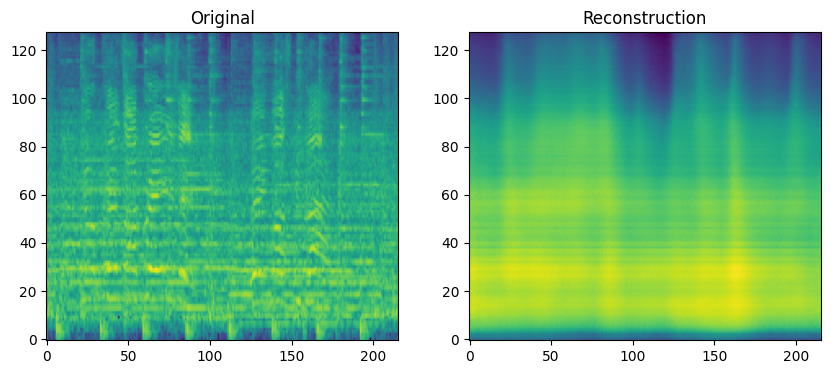

Model saved.


In [7]:
# Test the model on a few samples
model.eval()
with torch.no_grad():
    batch, paths = next(iter(loader))
    batch = batch.to(device)
    out, latents = model(batch)

import matplotlib.pyplot as plt

def show_reconstruction(original, reconstructed, idx=0):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(original[idx][0].cpu().numpy(), aspect="auto", origin="lower")
    axs[0].set_title("Original")
    axs[1].imshow(reconstructed[idx][0].cpu().numpy(), aspect="auto", origin="lower")
    axs[1].set_title("Reconstruction")
    plt.show()

show_reconstruction(batch, out)

# Save model
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/conv_autoencoder.pth")
print("Model saved.")